In [1]:
import pandas as pd
import os, glob
import pickle
import numpy as np
import matplotlib.pyplot as plt 
from stdb import load_db 
from  PlotCatalog import plot_nonnull_average
from obspy.taup import TauPyModel
from obspy.geodetics import kilometers2degrees, gps2dist_azimuth
model = TauPyModel(model="iasp91")

In [2]:
PKLpath = '/Volumes/home/Research/STEP/01_Split'
Path = '/Volumes/home/Research/STEP/02_Station_result_csv'
# RElook = ['KIV','GNI','ONI','AKH']
RElook= ['AKH']
SAVEpath = '/Users/tong/Document'
YearRange = '2010-2020'
ver=1

In [3]:
def Calc_rho(RCdt, SCdt):
    rho = RCdt/SCdt 
    return rho
def Calc_Phi(RCPhi, SCPhi):
    Phi = max (abs(RCPhi-SCPhi), abs(SCPhi-RCPhi))
    if Phi > 90: Phi = 180 - Phi
    return Phi
def phiPlot(ax):
    ax.set_ylabel('Fast Direction',fontsize=15)
#     ax.set_xlabel('Backazimuth',fontsize=15)
    ax.set_xlim(0,360)
    ax.set_ylim(-90,90)
    ax.grid(axis='y',color='lightgrey',lw=1)
    ax.set_xticks(range(0,361,30))
    ax.set_yticks(range(-90,91,30))
    ax.vlines(x=[90,180,270],ymin=-90,ymax=90,color='lightgrey',lw=1)
def dtPlot(ax,dtmean=None,dterror=None):
    ax.set_ylabel('dt (s)',fontsize=15)
    ax.set_xlabel('Backazimuth',fontsize=15)
    ax.set_xlim(0,360)
    ax.set_ylim(0,4.2)
    ax.grid(axis='y',color='lightgrey',lw=1)
    ax.set_yticks(np.arange(0,4.1,0.5))
    ax.set_yticklabels(['0','0.5','1','1.5','2','2.5','3','3.5','4'])
    ax.set_xticks(range(0,361,30))
    ax.vlines(x=[90,180,270],ymin=0,ymax=4.2,color='lightgrey',lw=1)
    if dtmean != None and dterror != None:
        ax.set_title(f'{round(dtmean,2)}$\pm${round(dterror,2)}(s)',fontsize=15)
def classify(df):
    phiRC = []; DphiRC = []; dtRC = []; DdtRC = []
    phiSC = []; DphiSC = []; dtSC = []; DdtSC = []
    BAZ = []; inc = []
    NULLBAZ_G = [] ; NULLdt_G = []; NULLRC = []; NULLSC=[]
    for i in range(len(df)):
        evlat = df['Ev_lat'].values[i]
        evlon = df['Ev_lon'].values[i]
        depth = df['Depth'].values[i]
        phase = df['Phase'].values[i]
        RCPhi = df['RCPhi'].values[i]
        RCDPhi  = df['RCPhi_std'].values[i]
        RCdt  = df['RCdt'].values[i]
        RCDdt  = df['RCdt_std'].values[i]
        SCPhi = df['SCPhi'].values[i]
        SCDPhi  = df['SCPhi_std'].values[i]
        SCdt  = df['SCdt'].values[i]
        SCDdt  = df['SCdt_std'].values[i]

        rho = Calc_rho(RCdt, SCdt)
        phi = Calc_Phi(RCPhi, SCPhi)
        dist, az, baz = gps2dist_azimuth(evlat,evlon,stlat,stlon)
        deg = kilometers2degrees(dist/1000)
        
        if 25 < phi < 68 or df["CpH"].values[i] > 0.76 :
            NULLBAZ_G.append(baz)
            NULLdt_G.append(4)
            NULLRC.append(float(RCPhi))
            NULLSC.append(float(SCPhi))
        elif 0.8 < rho < 1.1 and phi < 8:## non-null good condition 
            print(df['Event'].values[i])
            phiRC.append(float(RCPhi));DphiRC.append(float(RCDPhi));dtRC.append(float(RCdt));DdtRC.append(float(RCDdt))
            phiSC.append(float(SCPhi));DphiSC.append(float(SCDPhi));dtSC.append(float(SCdt));DdtSC.append(float(SCDdt))

            BAZ.append(baz)
            arrivals = model.get_travel_times(source_depth_in_km=depth,distance_in_degree=deg,phase_list=[phase])
            inc.append(arrivals[0].incident_angle)
        elif 0.7 <= rho < 1.2 and phi <= 25: ## non-null FAIR condition 
            print(df['Event'].values[i])
            phiRC.append(float(RCPhi));DphiRC.append(float(RCDPhi));dtRC.append(float(RCdt));DdtRC.append(float(RCDdt))
            phiSC.append(float(SCPhi));DphiSC.append(float(SCDPhi));dtSC.append(float(SCdt));DdtSC.append(float(SCDdt))
            BAZ.append(baz)
            arrivals = model.get_travel_times(source_depth_in_km=depth,distance_in_degree=deg,phase_list=[phase])
            inc.append(arrivals[0].incident_angle)
        else: 
            NULLBAZ_G.append(baz)
            NULLdt_G.append(4)
            NULLRC.append(float(RCPhi))
            NULLSC.append(float(SCPhi))
    result_df = {'phiRC': phiRC, 
                  'DphiRC': DphiRC, 
                  'dtRC': dtRC, 
                  'DdtRC': DdtRC,
                  'phiSC': phiSC, 
                  'DphiSC': DphiSC, 
                  'dtSC': dtSC, 
                  'DdtSC': DdtSC, 
                  'BAZ': BAZ, 
                  'inc': inc, 
                  'NULLBAZ' : NULLBAZ_G, 
                  'NULLdt': NULLdt_G,
                  'NULLRC':NULLRC,
                  'NULLSC':NULLSC}
    return  result_df

GO.AKH
57
20160804_141513
20120514_100039
20120706_022822
20121119_094435
20130704_171557
20130717_023743
20140316_211628
20140323_182001
20140403_015829
20140824_232141
20140824_232143
20130717_023743
20140413_123619
20160725_172650
20160804_141513
20120124_005204
20120423_173621
20140101_160329
20140207_084013
20140316_211628
20140501_063636
20160720_151316
20160725_172650
20161104_162043
20170415_081943
20170509_135210


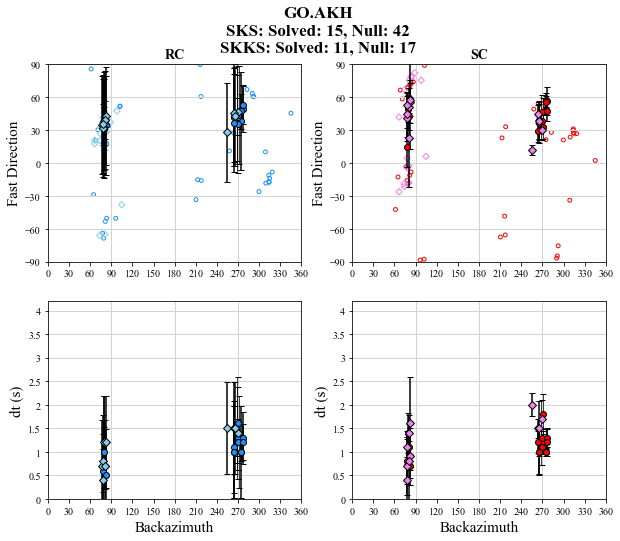

6.12151893125 10.9270818611


In [4]:
for relook in RElook:
    for STApath in glob.glob(f'{PKLpath}/*{relook}.pkl'):
        STApkl = pickle.load(open(STApath, "rb"))
        values = [value for keys, value in STApkl.items() ][0]

        NET = values['network']; STA = values['station']
        print(f'{NET}.{STA}')    
        stlat = values['latitude']; stlon = values['longitude']
        plt.rc('font',family='Times New Roman')
        plt.figure(figsize=(10,8))
        ax1 = plt.subplot(221); ax2 = plt.subplot(222)
        ax3 = plt.subplot(223); ax4 = plt.subplot(224)

        newdf = pd.DataFrame()
        for csvpath in glob.glob(f'{Path}/*SKS/{NET}*{STA}*.csv'):
            df = pd.read_csv(csvpath)
            df = df[df['SNRQ']>=5][df['Pick']==True][df['Phase']=='SKS']
            newdf = newdf.append(df)     
        print(len(newdf))
        SKSresult_df= classify(newdf)
        print('='*50)
        
        newdf = pd.DataFrame()
        for csvpath in glob.glob(f'{Path}/*SKKS/{NET}*{STA}*.csv'):
            df = pd.read_csv(csvpath)
            df = df[df['SNRQ']>=5][df['Pick']==True][df['Phase']=='SKKS']
            newdf = newdf.append(df)  
        SKKSresult_df = classify(newdf)
        
        ax1.errorbar(SKSresult_df['BAZ'],SKSresult_df['phiRC'],yerr=SKSresult_df['DphiRC'],fmt='o',markeredgecolor='k',color ='dodgerblue' ,ecolor='k',capsize=3,label='SKS')
        ax1.errorbar(SKKSresult_df['BAZ'],SKKSresult_df['phiRC'],yerr=SKKSresult_df['DphiRC'],fmt='D',markeredgecolor='k',color ='skyblue' ,ecolor='k',capsize=3,label='SKKS')
        ax1.scatter(SKSresult_df['NULLBAZ'],SKSresult_df['NULLRC'],marker='o',c='none',edgecolors='dodgerblue',s=15,label='SKS null')
        ax1.scatter(SKKSresult_df['NULLBAZ'],SKKSresult_df['NULLRC'],marker='D',c='none',edgecolors='skyblue',s=20,label='SKKS null')
        ax1.set_title('RC', fontsize=14, fontweight='bold')
        phiPlot(ax1)

        ax2.errorbar(SKSresult_df['BAZ'],SKSresult_df['phiSC'],yerr=SKSresult_df['DphiSC'],fmt='o',markeredgecolor='k',color ='r' ,ecolor='k',capsize=3)
        ax2.errorbar(SKKSresult_df['BAZ'],SKKSresult_df['phiSC'],yerr=SKKSresult_df['DphiSC'],fmt='D',markeredgecolor='k',color ='violet' ,ecolor='k',capsize=3)
        ax2.scatter(SKSresult_df['NULLBAZ'],SKSresult_df['NULLSC'],marker='o',c='none',edgecolors='r',s=15)
        ax2.scatter(SKKSresult_df['NULLBAZ'],SKKSresult_df['NULLSC'],marker='D',c='none',edgecolors='violet',s=20)
        ax2.set_title('SC', fontsize=14, fontweight='bold')
        phiPlot(ax2)

        ax3.errorbar(SKSresult_df['BAZ'],SKSresult_df['dtRC'],yerr=SKSresult_df['DdtRC'],fmt='o',markeredgecolor='k',color ='dodgerblue' ,ecolor='k',capsize=3)
        ax3.errorbar(SKKSresult_df['BAZ'],SKKSresult_df['dtRC'],yerr=SKKSresult_df['DdtRC'],fmt='D',markeredgecolor='k',color ='skyblue' ,ecolor='k',capsize=3)
        dtPlot(ax3)

        ax4.errorbar(SKSresult_df['BAZ'],SKSresult_df['dtSC'],yerr=SKSresult_df['DdtSC'],fmt='o',markeredgecolor='k',color ='r' ,ecolor='k',capsize=3)
        ax4.errorbar(SKKSresult_df['BAZ'],SKKSresult_df['dtSC'],yerr=SKKSresult_df['DdtSC'],fmt='D',markeredgecolor='k',color ='violet' ,ecolor='k',capsize=3)
        dtPlot(ax4)
        
        SKSSolved  = len(SKSresult_df['phiRC'])
        SKKSSolved = len(SKKSresult_df['phiRC'])
        SKSNull    = len(SKSresult_df['NULLSC'])
        SKKSNull    = len(SKKSresult_df['NULLSC'])
        plt.suptitle(f'{NET}.{STA}\nSKS: Solved: {SKSSolved}, Null: {SKSNull}\nSKKS: Solved: {SKKSSolved}, Null: {SKKSNull}', fontsize=17, fontweight='bold')
        plt.show()
        plt.close()
        print(np.mean(SKSresult_df['inc']),np.mean(SKKSresult_df['inc']))

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from orix import vector
new_params = {
    "figure.figsize": (10, 5),
    "lines.markersize": 10,
    "font.size": 20,
    "axes.grid": False,
}
plt.rcParams.update(new_params)

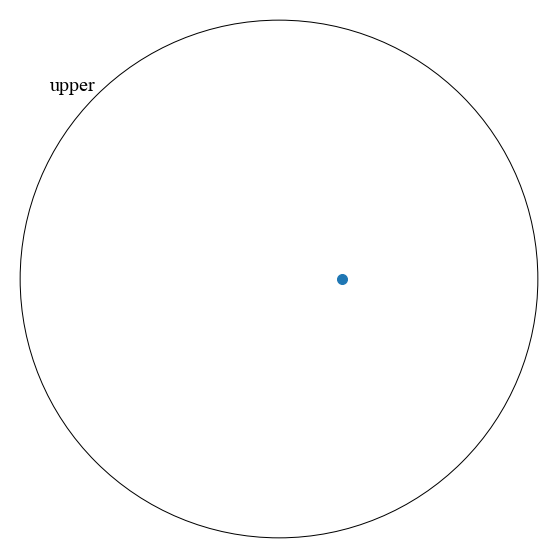

In [33]:
subplot_kw = dict(
    projection="stereographic", polar_resolution=30, azimuth_resolution=10
)
fig, ax = plt.subplots(ncols=1, figsize=(10, 10), subplot_kw=subplot_kw)
v3 = vector.Vector3d([[90, 0, 175]])
v4 = vector.Vector3d(np.append(v3.data, -v3.data, axis=0))
ax.scatter(v4)
ax.show_hemisphere_label()



In [13]:
v4

Vector3d (6,)
[[ 0  0  1]
 [ 1  0  1]
 [ 1  1  1]
 [ 0  0 -1]
 [-1  0 -1]
 [-1 -1 -1]]